<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20221101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterator

In [20]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotnine as gg
from plotnine import ggplot, aes
import re
import os 
from datetime import datetime, date, time, timezone, timedelta

from functools import reduce 
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Customer Analysis

In [2]:
os.listdir()

['.config',
 'sample-sales-data.csv',
 '1_orders_dataset.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 'groceries.csv',
 'mall_customers.csv',
 'scanner_data.csv',
 'sales_data_with_stores.csv',
 'online_retail.xlsx',
 'online_retail_II.xlsx',
 '1_order_payments_dataset.csv',
 'ecommerce-data.csv',
 'sales.csv',
 'mock_sales_data.csv',
 'sales_vs_discount.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 '1_customers_dataset.csv',
 'test.csv',
 'match_result_test.csv',
 'sample_data']

In [7]:
df = pd.read_csv('ecommerce-data.csv', encoding = 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
df.columns = ['_'.join(re.split('(?=[A-Z][a-z])', a[0].lower() + a[1:])).lower() for a in df.columns]
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [9]:
df = df[(~df.invoice_no.astype(str).str.contains('C')) & (df.country == 'United Kingdom')]
df.invoice_date = pd.to_datetime(df.invoice_date, infer_datetime_format=True)
df['date'] = df.invoice_date.to_numpy().astype('datetime64[D]')
df['week'] = df['date'] - df['date'].dt.weekday.astype('timedelta64[D]')
df['rev'] = df.quantity * df.unit_price
df = df.groupby(['customerid', 'date', 'week'])['rev'].sum().reset_index().rename(columns = {'customerid':'id'})
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,date,week,rev
0,12346.0,2011-01-18,2011-01-17,77183.60
1,12747.0,2010-12-05,2010-11-29,358.56
2,12747.0,2010-12-13,2010-12-13,347.71
3,12747.0,2011-01-20,2011-01-17,303.04
4,12747.0,2011-03-01,2011-02-28,310.78


In [11]:
df = df.groupby(['id','week'])['rev'].sum().reset_index().sort_values(['id','week'])
df.head()

,id,week,rev
0,12346.0,2011-01-17,77183.60
1,12747.0,2010-11-29,358.56
2,12747.0,2010-12-13,347.71
3,12747.0,2011-01-17,303.04
4,12747.0,2011-02-28,310.78


In [12]:
list_npu = df.groupby(['id']).head(1)
list_week = df['week'].sort_values().unique()

In [15]:
res = list()

for weeks in list_week :

  temp_npu = list_npu[list_npu['week'] == weeks]
  temp_pu = df[df['id'].isin(temp_npu['id'])]
  temp = temp_pu.groupby(['week'])['id'].count().reset_index().rename(columns = {'id':'pu'})
  temp['npu_week'] = np.repeat(weeks, len(temp))
  temp['diff'] = (temp['week'] - temp['npu_week']).dt.days // 7 
  temp['ratio'] = round(temp['pu']/temp['pu'].max() * 100, 2)

  temp = temp[['npu_week', 'diff', 'pu','ratio']]
  temp['npu_week'] = temp['npu_week'].astype(str)
  res.append(temp)

res = pd.concat(res)
res = pd.melt(res, id_vars = ['npu_week', 'diff'], var_name = 'type')
res.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,npu_week,diff,type,value
0,2010-11-29,0,pu,278.0
1,2010-11-29,1,pu,58.0
2,2010-11-29,2,pu,67.0
3,2010-11-29,3,pu,19.0
4,2010-11-29,5,pu,56.0


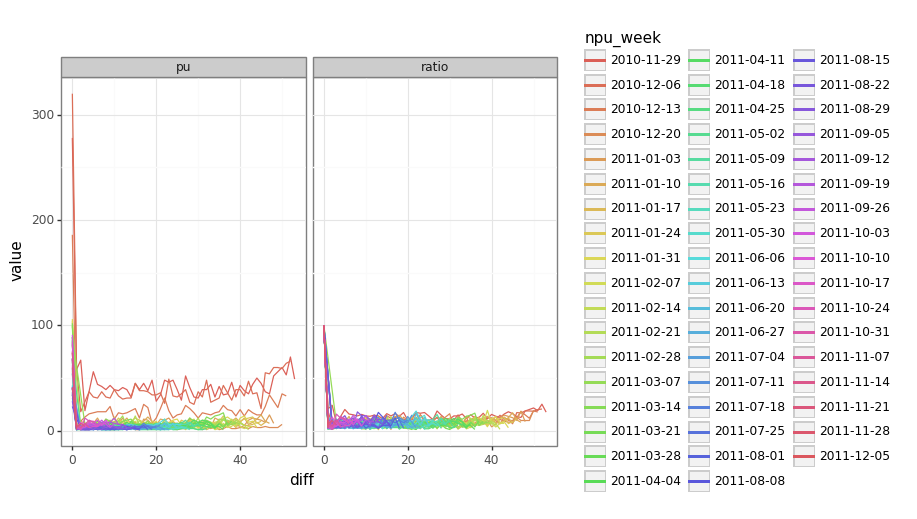

<ggplot: (8784608160469)>

In [17]:
(
    ggplot(res, aes('diff', 'value', color = 'npu_week')) +
    gg.geom_line() +
    gg.facet_wrap('~type') +
    gg.theme_bw()
)

# Iterator

In [18]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [21]:
{k : eval(f'reduce(lambda acc, cur : acc + [cur["{k}"]], users, [])') for k in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}

In [22]:
a = [
    {'name' : 'aaa', 'age' : 10},
    {'name' : 'bbb', 'age' : 20},
    {'name' : 'ccc', 'age' : 30},
    {'name' : 'ddd', 'age' : 40},
    {'name' : 'eee', 'age' : 50}
]
a

[{'name': 'aaa', 'age': 10},
 {'name': 'bbb', 'age': 20},
 {'name': 'ccc', 'age': 30},
 {'name': 'ddd', 'age': 40},
 {'name': 'eee', 'age': 50}]

In [26]:
reduce(lambda x, y : x + y['age'], a, 0)

150

In [27]:
reduce(lambda x, y : x + [y['age']], a, [])

[10, 20, 30, 40, 50]